In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import os 

import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import Model 
from tensorflow.keras.layers import Input , GlobalAveragePooling2D , BatchNormalization , Dropout , Dense 
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping 

!nvidia-smi

In [2]:
dir = "/kaggle/input/state-farm-distracted-driver-detection"
train_dir = os.path.join(dir , 'imgs/train/')
test_dir = os.path.join(dir , 'imgs/test/')
data = pd.read_csv(os.path.join(dir , 'driver_imgs_list.csv'))

In [3]:
data.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
classes = {   'c0' : "safe_driving",
                      'c1' : "texting-right",
                      'c2' : "talking_on_the_phone-right",
                      'c3' : "texting-left",
                      'c4' : "talking_on_the_phone-left",
                      'c5' : "operating_the_radio",
                      'c6' : "drinking",
                      'c7' : "reaching_behind",
                      'c8' : "hair-and-makeup",
                      'c9' : "talking_to_passenger"}
class_counts = data.classname.value_counts()


In [5]:
px.histogram(data , x="classname" ,  color="classname", title="Images By Categories ")

In [6]:
px.histogram(data , x="subject" ,  color="subject", title="Images By Subject ")

In [31]:
values=[]
for i in data['classname'].value_counts():
    values.append(i)
    
keys=[]
for i in range(10):
    keys.append('c'+str(i))

px.pie(values=values, names=keys)

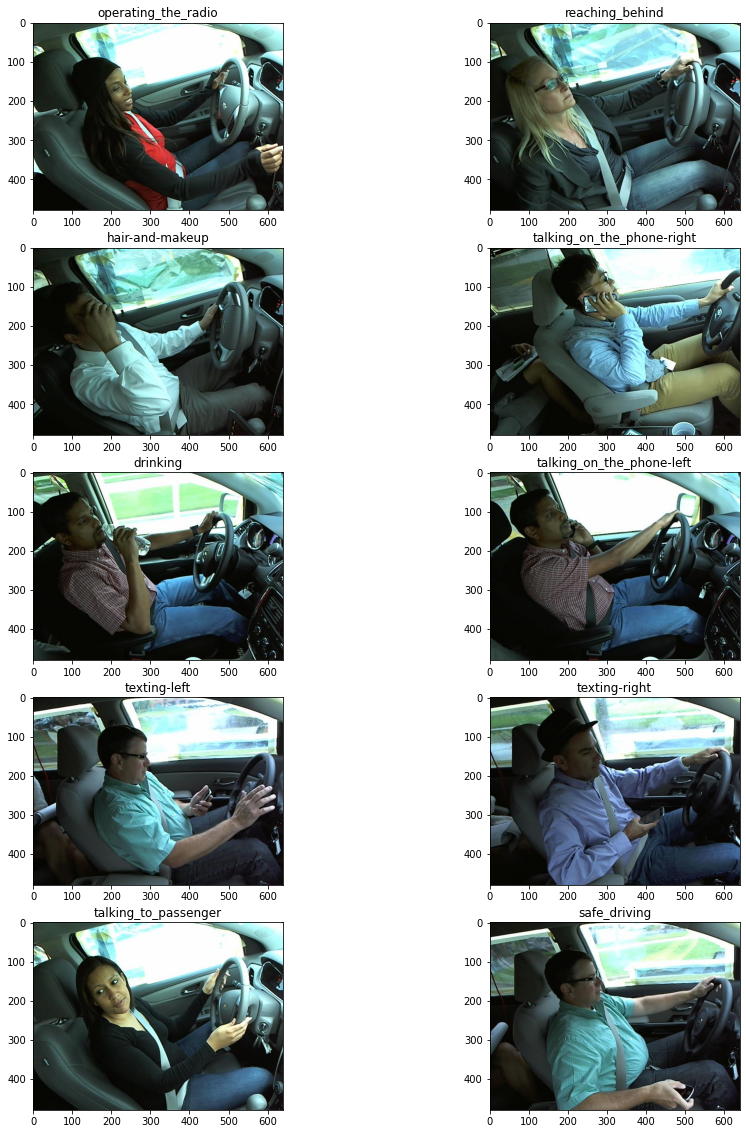

In [7]:
plt.figure(figsize = (15, 20))
count = 1
for directory in os.listdir(train_dir):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(train_dir + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, count)
                count += 1
                image =cv2.imread(train_dir + directory + '/' + file)
                img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.title(classes[directory])

In [8]:
IMG_SIZE = (224 ,224)
BATCH_SIZE = 64

In [9]:
train_gen = ImageDataGenerator(width_shift_range = 0.3,
                               height_shift_range = 0.3,
                               shear_range = 0.3,
                               zoom_range = 0.4,
                               validation_split = 0.2)

test_gen = ImageDataGenerator()

In [10]:
train_data = train_gen.flow_from_directory(train_dir,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         subset='training',
                                         seed = 42)
val_data = train_gen.flow_from_directory(train_dir,
                                         target_size=IMG_SIZE,
                                         batch_size=BATCH_SIZE,
                                         subset='validation',
                                         seed = 42)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


def model(num_class):
    inputs = Input(shape=(224,224,3))
    base = EfficientNetB3(include_top = False,
                         weights='imagenet')(inputs)
    x = GlobalAveragePooling2D()(base)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_class , activation='softmax')(x)
    
    model = Model(inputs = inputs , outputs = outputs)
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.optimizers.Adam(1e-4),
                 metrics = ['accuracy'])
    return model

num_class = len(class_counts )
num_class

In [11]:
model=tf.keras.Sequential()
#inputs = Input(shape=(224,224,3))
base = EfficientNetB3(include_top = False,
                     weights='imagenet',input_shape=(224,224,3),classes=10)
model.add(base)
#x = GlobalAveragePooling2D()(base)
model.add(GlobalAveragePooling2D())
#x = BatchNormalization()(x)
model.add(BatchNormalization())
#x = Dropout(0.2)(x)
model.add(Dropout(0.2))
#outputs = Dense(10 , activation='softmax')(x)
model.add(Dense(10 , activation='softmax'))
#model = Model(inputs = inputs , outputs = outputs)
model.compile(loss = 'categorical_crossentropy',
            optimizer = tf.optimizers.Adam(1e-4),
            metrics = ['accuracy'])

43950080/43941136 [==============================] - 0s 0us/step


In [12]:
#model = model(num_class)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 10,805,049
Trainable params: 10,714,674
Non-trainable params: 90,375
_________________________________________________________________


In [13]:
ck = ModelCheckpoint('best_model.hdf5' , save_best_only=True,monitor='val_loss',mode='min')
es = EarlyStopping(monitor = 'val_loss', patience = 5)


from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

 tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [14]:
history = model.fit(train_data , 
                   epochs = 10 ,
                   validation_data = val_data ,
                   callbacks=[es,ck],
                   verbose = 1)

Epoch 1/10
281/281 [==============================] - 569s 2s/step - loss: 0.9564 - accuracy: 0.6969 - val_loss: 0.2331 - val_accuracy: 0.9297


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
281/281 [==============================] - 454s 2s/step - loss: 0.2073 - accuracy: 0.9332 - val_loss: 0.1126 - val_accuracy: 0.9652
Epoch 3/10
281/281 [==============================] - 454s 2s/step - loss: 0.1278 - accuracy: 0.9588 - val_loss: 0.0792 - val_accuracy: 0.9757
Epoch 4/10
281/281 [==============================] - 453s 2s/step - loss: 0.0910 - accuracy: 0.9713 - val_loss: 0.0600 - val_accuracy: 0.9819
Epoch 5/10
281/281 [==============================] - 451s 2s/step - loss: 0.0728 - accuracy: 0.9767 - val_loss: 0.0430 - val_accuracy: 0.9864
Epoch 6/10
281/281 [==============================] - 448s 2s/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.0426 - val_accuracy: 0.9868
Epoch 7/10
281/281 [==============================] - 447s 2s/step - loss: 0.0491 - accuracy: 0.9833 - val_loss: 0.0439 - val_accuracy: 0.9866
Epoch 8/10
281/281 [==============================] - 449s 2s/step - loss: 0.0401 - accuracy: 0.9872 - val_loss: 0.0357 - val_accuracy: 0.9882

In [22]:
def plot_accuracy_loss(history):
    """
        We plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

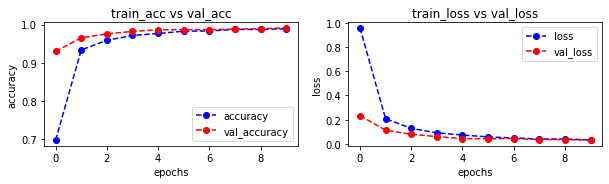

In [23]:
plot_accuracy_loss(history)

In [15]:
test_dir = os.path.join(dir , 'imgs')
test_data = test_gen.flow_from_directory(test_dir ,
                                        target_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE,
                                        classes = ['test'],
                                        shuffle = False)


Found 79726 images belonging to 1 classes.


In [16]:
from tensorflow.keras.models import load_model
model = load_model('./best_model.hdf5')

In [17]:
preds = model.predict(test_data)
preds

array([[6.59330835e-05, 1.57602858e-06, 8.12416943e-08, ...,
        2.63920015e-06, 1.79830194e-03, 9.85731781e-01],
       [1.09372858e-03, 5.57766634e-06, 3.36405530e-04, ...,
        5.75679354e-04, 6.30006015e-01, 1.35605903e-02],
       [2.64730281e-03, 5.94020158e-08, 2.54517249e-06, ...,
        7.29384265e-05, 9.88201916e-01, 9.05842241e-03],
       ...,
       [1.43613545e-06, 2.54011084e-05, 3.36932453e-06, ...,
        2.71986151e-04, 9.67363536e-01, 1.41859069e-04],
       [1.13256965e-05, 2.23260358e-07, 4.59850708e-06, ...,
        6.47396348e-07, 9.95201111e-01, 1.07178721e-05],
       [2.61832873e-04, 2.91983033e-05, 5.05960134e-06, ...,
        1.65488585e-04, 1.12583982e-02, 1.16102351e-03]], dtype=float32)

In [18]:
len(preds)

79726

In [19]:
test_imgs = os.path.join(dir , 'imgs/test')
test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
for i in range(len(preds)):
    pred_df.loc[i,'img'] = test_ids[i]
    pred_df.loc[i , 'c0':'c9'] = preds[i]
    

In [20]:
pred_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.000066,0.000002,0.0,0.001488,0.000003,0.010909,0.0,0.000003,0.001798,0.985732
1,img_10.jpg,0.001094,0.000006,0.000336,0.000004,0.000181,0.354087,0.00015,0.000576,0.630006,0.013561
2,img_100.jpg,0.002647,0.0,0.000003,0.000006,0.0,0.000005,0.000005,0.000073,0.988202,0.009058
3,img_1000.jpg,0.000002,0.0,0.000003,0.0,0.000005,0.0,0.000003,0.0,0.999986,0.000001
4,img_100000.jpg,0.00007,0.0,0.0,0.072327,0.000115,0.000013,0.000018,0.000161,0.924617,0.002678
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.000013,0.565908,0.000007,0.000017,0.000008,0.000365,0.000016,0.012721,0.379557,0.041389
79722,img_99995.jpg,0.000001,0.000001,0.0,0.987088,0.000003,0.000055,0.000003,0.005659,0.006506,0.000684
79723,img_99996.jpg,0.000001,0.000025,0.000003,0.002691,0.029462,0.000039,0.0,0.000272,0.967364,0.000142
79724,img_99998.jpg,0.000011,0.0,0.000005,0.000001,0.000018,0.000003,0.004748,0.000001,0.995201,0.000011


In [21]:
pred_df.to_csv('submission.csv',index = False)

2489
2346
2326
2325
2317
2312
2267
2129
2002
1911
